# Flight Delay Prediction Pipeline

## Objectives
1. **Data Loading**: Load flight and plane data.
2. **Variable Selection & Transformation**: Clean data, handle missing values, and transform features.
3. **Feature Engineering**: Create derived variables (e.g., Polar coordinates for time).
4. **Model Training**: Train Regression models (Linear, Decision Tree, Random Forest) to predict `ArrDelay`.
5. **Validation**: Evaluate models using RMSE, MAE, and R2.
6. **Artifact Storage**: Save the **Best Model** and **Preprocessing Parameters** for the production app.

In [1]:
# =================== 1. Environment Setup ===================
import os
import shutil
import json
import logging
from math import pi

from pyspark.sql import SparkSession, DataFrame, functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("Trainer")

spark = SparkSession.builder \
    .appName("ProductionModelTrainer") \
    .config("spark.sql.caseSensitive", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/08 00:38:34 WARN Utils: Your hostname, MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.162 instead (on interface en0)
26/01/08 00:38:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 00:38:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# =================== 2. Pipeline Configuration ===================
# Define constants to ensure consistency with app.py

class Config:
    # Paths
    RAW_FLIGHTS_DIR = "training_data/flight_data/"
    RAW_PLANES_FILE = "training_data/flight_data/plane-data.csv"
    STAGING_DIR = "data/staging/"
    ARTIFACTS_DIR = "best_model/encoders/"
    MODEL_OUTPUT_DIR = "best_model/_best_model/"
    
    # Columns that introduce leakage or are irrelevant
    LEAKAGE_COLS = [
        "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted", 
        "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"
    ]
    
    METADATA_COLS = [
        "TailNum", "FlightNum", "UniqueCarrier", "CancellationCode", "Cancelled", 
        "issue_date", "status", "type"
    ]
    
    # Renaming map for standardization
    SCHEMA_MAP = {
        "year": "PlaneIssueYear", 
        "engine_type": "EngineType", 
        "aircraft_type": "AircraftType", 
        "model": "Model", 
        "manufacturer": "Manufacturer"
    }

    # Threshold to switch from OneHotEncoding to MeanEncoding
    CARDINALITY_THRESHOLD = 10

# Clean up old runs
if os.path.exists(Config.ARTIFACTS_DIR):
    shutil.rmtree(Config.ARTIFACTS_DIR)
os.makedirs(Config.ARTIFACTS_DIR, exist_ok=True)

In [3]:
# =================== 3. Data Ingestion Manager ===================
class DataManager:
    def __init__(self, spark_session):
        self.spark = spark_session
        
    def load_raw_dataset(self, path_pattern, alias):
        """
        Reads CSVs, handles wildcard paths, and caches to Parquet for performance.
        """
        parquet_path = os.path.join(Config.STAGING_DIR, f"{alias}.parquet")
        
        if os.path.exists(parquet_path):
            logger.info(f"Fast-loading cached data: {alias}")
            return self.spark.read.parquet(parquet_path)
        
        logger.info(f"Ingesting raw data from: {path_pattern}")
        # Handle BZ2/CSV reading with loose schema inference
        df = self.spark.read.option("header", "true") \
            .option("inferSchema", "true") \
            .option("nullValue", "NA") \
            .csv(path_pattern)
            
        # Cache for subsequent runs
        df.write.mode("overwrite").parquet(parquet_path)
        return self.spark.read.parquet(parquet_path)

In [4]:
# =================== 4. Feature Engineering Pipeline ===================
class FeaturePipeline:
    """
    Manages the transformation of raw data into training features.
    Responsibility: Clean, Transform, Learn Parameters, and Save Artifacts.
    """
    def __init__(self, output_dir):
        self.output_dir = output_dir
        self.numeric_features = ['CRSElapsedTime', 'DepDelay', 'Distance', 'TaxiOut']
        self.categorical_features = [
            'Origin', 'Dest', 'EngineType', 'AircraftType', 'Manufacturer', 'Model',
            'Year', 'PlaneIssueYear'
        ]
        
    def _apply_cyclic_transform(self, df):
        """Native Spark implementation of cyclic time features (Matches app.py logic)."""
        logger.info("Generating cyclic time features...")
        
        # 1. Transform to Radians
        df = df.withColumn("rad_month", (F.col("Month") / 12) * 2 * pi)
        df = df.withColumn("rad_dow", (F.col("DayOfWeek") / 7) * 2 * pi)
        
        # Days in month logic
        days_in_month = F.when(F.col("Month") == 2, 28) \
                         .when(F.col("Month").isin([4, 6, 9, 11]), 30) \
                         .otherwise(31)
        df = df.withColumn("rad_dom", (F.col("DayofMonth") / days_in_month) * 2 * pi)
        
        # 2. Sin/Cos Generation
        for base, rad in [("Month", "rad_month"), ("DayOfWeek", "rad_dow"), ("DayofMonth", "rad_dom")]:
            df = df.withColumn(f"{base}_sin", F.sin(F.col(rad))) \
                   .withColumn(f"{base}_cos", F.cos(F.col(rad)))
                   
        return df.drop("rad_month", "rad_dow", "rad_dom")

    def _parse_times(self, df):
        """Parses HHMM time columns to minutes."""
        for col in ['DepTime', 'CRSDepTime', 'CRSArrTime']:
            # Coerce to int safely
            df = df.withColumn(col, F.col(col).cast("int"))
            # HH * 60 + MM
            df = df.withColumn(f"{col}_minutes", (F.floor(F.col(col) / 100) * 60) + (F.col(col) % 100))
            df = df.fillna(0, subset=[f"{col}_minutes"])
            self.numeric_features.append(f"{col}_minutes")
        return df.drop('DepTime', 'CRSDepTime', 'CRSArrTime')

    def clean_and_standardize(self, df_flights, df_planes):
        logger.info("Starting cleaning and standardization...")
        
        # Join
        df_planes = df_planes.withColumnRenamed("tailnum", "TailNum")
        df = df_flights.join(df_planes, on="TailNum", how="inner")
        
        # Filter Cancelled
        df = df.filter(F.col("Cancelled") == 0)
        
        # Drop Unwanted
        df = df.drop(*(Config.LEAKAGE_COLS + Config.METADATA_COLS))
        
        # Rename
        for old, new in Config.SCHEMA_MAP.items():
            df = df.withColumnRenamed(old, new)
            
        # Cast Numerics & Label
        for c in self.numeric_features + ["ArrDelay"]:
            if c in df.columns:
                df = df.withColumn(c, F.col(c).cast("int"))
                
        return df.dropna(subset=["ArrDelay"])

    def build_features(self, df):
        df = self._parse_times(df)
        df = self._apply_cyclic_transform(df)
        return df
    
    def fit_and_save_artifacts(self, df):
        """
        Learns imputation and encoding parameters and saves them in the exact format app.py expects.
        """
        logger.info("Learning parameters and saving artifacts...")
        
        # 1. Imputer (Medians/Modes)
        impute_map = {}
        for col in self.numeric_features:
            median = df.approxQuantile(col, [0.5], 0.01)[0]
            impute_map[col] = {"fill_value": median, "extra_nulls": []}
            
        for col in self.categorical_features:
            mode = df.groupby(col).count().orderBy(F.desc("count")).first()[0]
            impute_map[col] = {"fill_value": mode, "extra_nulls": ["None", "NA"]}
            
        with open(os.path.join(self.output_dir, 'imputer_maps.json'), 'w') as f:
            json.dump(impute_map, f, indent=4)

        # 2. Categorical Encoding (Hybrid OHE/Mean)
        encode_types = {}
        valid_groups = {}
        final_cols_for_vectorizer = self.numeric_features + \
                                    [c for c in df.columns if "_sin" in c or "_cos" in c]
        
        total_count = df.count()
        
        for col_name in self.categorical_features:
            # Frequency Thresh: Keep cats with > 1% freq, else 'Other'
            freq = df.groupBy(col_name).agg((F.count("*")/total_count).alias("freq")) \
                     .filter(F.col("freq") > 0.01).select(col_name).collect()
            valid_cats = [r[0] for r in freq]
            valid_groups[col_name] = valid_cats
            
            # Create temp agg column for fitting
            df_tmp = df.withColumn(f"{col_name}_agg", 
                                   F.when(F.col(col_name).isin(valid_cats), F.col(col_name))
                                   .otherwise(F.lit("Other")))
            
            agg_col = f"{col_name}_agg"
            
            if len(valid_cats) <= Config.CARDINALITY_THRESHOLD:
                # Low Cardinality -> OHE
                logger.info(f"Encoding {col_name} via OneHot")
                indexer = StringIndexer(inputCol=agg_col, outputCol=f"{col_name}_idx", handleInvalid='keep')
                encoder = OneHotEncoder(inputCol=f"{col_name}_idx", outputCol=f"{col_name}_vec", dropLast=True)
                
                # Save pipeline for app.py (Naming convention: {col}_aggregated_encoder)
                Pipeline(stages=[indexer, encoder]).fit(df_tmp).save(os.path.join(self.output_dir, f"{col_name}_aggregated_encoder"))
                
                encode_types[agg_col] = "binary"
                final_cols_for_vectorizer.append(f"{col_name}_vec")
            else:
                # High Cardinality -> Mean Target
                logger.info(f"Encoding {col_name} via MeanTarget")
                mapping = df_tmp.groupBy(agg_col).agg(F.avg("ArrDelay").alias(f"{col_name}_mean_enc"))
                
                # Save CSV for app.py (Naming convention: {col}_aggregated_encoder.csv)
                mapping.write.mode("overwrite").option("header", "true").csv(os.path.join(self.output_dir, f"{col_name}_aggregated_encoder.csv"))
                
                encode_types[agg_col] = "mean"
                final_cols_for_vectorizer.append(f"{col_name}_mean_enc")

        # Save Metadata
        with open(os.path.join(self.output_dir, 'encode_types.json'), 'w') as f: json.dump(encode_types, f)
        with open(os.path.join(self.output_dir, 'non_aggregated.json'), 'w') as f: json.dump(valid_groups, f)

        # 3. Vectorizer (The final artifact)
        logger.info("Saving Vectorizer model...")
        assembler = VectorAssembler(inputCols=final_cols_for_vectorizer, outputCol="features", handleInvalid="skip")
        # We fit on dummy data just to save the pipeline structure
        Pipeline(stages=[assembler]).fit(df).save(os.path.join(self.output_dir, 'vectorizer'))
        
        logger.info("All artifacts saved successfully.")
        return final_cols_for_vectorizer

In [5]:
# =================== 5. Model Training Manager (Improved) ===================
import pandas as pd
import numpy as np
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

class ModelTrainer:
    def __init__(self, output_dir):
        self.output_dir = output_dir
        self.models = {
            "LinearReg": LinearRegression(featuresCol="features", labelCol="ArrDelay"),
            "RandomForest": RandomForestRegressor(featuresCol="features", labelCol="ArrDelay", numTrees=20, maxDepth=8)
        }
        # Define multiple evaluators
        self.evaluators = {
            "RMSE": RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse"),
            "MAE": RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae"),
            "R2": RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")
        }

    def _extract_feature_names(self, df, features_col="features"):
        """
        Robustly extracts flattened feature names from VectorAssembler metadata.
        This ensures the number of names matches the model coefficients exactly.
        """
        try:
            schema = df.schema[features_col]
            meta = schema.metadata
            
            if "ml_attr" not in meta:
                return None
            
            attrs = meta["ml_attr"]["attrs"]
            # Spark groups attributes by type (numeric, binary, nominal). We must merge and sort by index.
            features_dict = {}
            
            for attr_type in ["numeric", "binary", "nominal"]:
                if attr_type in attrs:
                    for attr in attrs[attr_type]:
                        # idx is the index in the dense vector
                        features_dict[attr["idx"]] = attr["name"]
            
            # Sort by index to match coefficient order
            sorted_features = [features_dict[i] for i in range(len(features_dict))]
            return sorted_features
        except Exception as e:
            print(f"WARN: Could not extract feature metadata: {e}")
            return None

    def train_and_evaluate(self, train_df, test_df, original_feature_cols_hint):
        """
        Trains models, calculates RMSE/MAE/R2, and saves feature importance.
        """
        best_metric = float('inf') # Minimizing RMSE
        best_model = None
        best_name = None
        
        metrics_data = []
        importance_data = []

        # 1. Extract correct feature names from metadata (handles OHE expansion)
        real_feature_names = self._extract_feature_names(train_df)
        if not real_feature_names:
            print("WARN: Fallback to original col names (Length mismatch likely!)")
            real_feature_names = original_feature_cols_hint

        print(f"{'Model':<15} | {'RMSE':<10} | {'MAE':<10} | {'R2':<10}")
        print("-" * 55)

        for name, algo in self.models.items():
            # Train
            model = algo.fit(train_df)
            
            # Evaluate
            preds = model.transform(test_df)
            
            rmse = self.evaluators["RMSE"].evaluate(preds)
            mae = self.evaluators["MAE"].evaluate(preds)
            r2 = self.evaluators["R2"].evaluate(preds)
            
            print(f"{name:<15} | {rmse:<10.4f} | {mae:<10.4f} | {r2:<10.4f}")
            
            metrics_data.append({
                "Model": name, 
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2
            })
            
            # Extract Feature Importance / Coefficients
            importances = None
            if hasattr(model, "featureImportances"): # Random Forest
                importances = model.featureImportances.toArray()
            elif hasattr(model, "coefficients"): # Linear Regression
                importances = np.abs(model.coefficients.toArray())
            
            # Only save if lengths match (Metadata extraction fixes the mismatch!)
            if importances is not None:
                if len(importances) == len(real_feature_names):
                    for feat, imp in zip(real_feature_names, importances):
                        importance_data.append({"Model": name, "Feature": feat, "Importance": float(imp)})
                else:
                    print(f"WARN: {name} feature count mismatch. Coeffs: {len(importances)}, Names: {len(real_feature_names)}")

            # Track Winner (based on RMSE)
            if rmse < best_metric:
                best_metric = rmse
                best_model = model
                best_name = name
        
        # Save CSVs
        pd.DataFrame(metrics_data).to_csv(os.path.join(self.output_dir, "model_metrics.csv"), index=False)
        
        # Check if importance data exists before saving to avoid EmptyDataError
        if importance_data:
            pd.DataFrame(importance_data).to_csv(os.path.join(self.output_dir, "feature_importances.csv"), index=False)
        else:
            print("WARN: No feature importance data could be extracted.")
                
        return best_name, best_model

In [6]:
# =================== 5a. Visualization & Interpretation Helpers ===================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import VectorUDT

def generate_evidence_graphs(df):
    """
    Generates EDA graphs (Correlation & Missing Values) on the raw/cleaned data.
    """
    print(">>> Generating Evidence Graphs...")
    
    # --- 1. Correlation Matrix ---
    # List of ideal columns we WANT to check
    desired_cols = ['ArrDelay', 'DepDelay', 'Distance', 'TaxiOut', 'CRSElapsedTime']
    numeric_cols = [c for c in desired_cols if c in df.columns]
    
    if len(numeric_cols) >= 2:
        assembler = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
        # Dropna ensures correlation doesn't fail
        df_vector = assembler.transform(df.dropna(subset=numeric_cols)).select("corr_features")
        
        matrix = Correlation.corr(df_vector, "corr_features").head()[0]
        corr_array = matrix.toArray()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_array, annot=True, fmt=".2f", cmap='coolwarm', 
                    xticklabels=numeric_cols, yticklabels=numeric_cols)
        plt.title("Feature Correlation Matrix")
        plt.show()
    else:
        print(f"Skipping Correlation Matrix: Not enough numeric columns found.")

    # --- 2. Missing Values Analysis ---
    null_counts = []
    for col_name in df.columns:
        cond = F.col(col_name).isNull()
        # Check for "NA" string only if column is StringType
        if isinstance(df.schema[col_name].dataType, StringType):
            cond = cond | (F.col(col_name) == "NA") | (F.col(col_name) == "None")
        
        count = df.filter(cond).count()
        if count > 0:
            null_counts.append({'Feature': col_name, 'Missing_Count': count})
            
    if null_counts:
        pdf_null = pd.DataFrame(null_counts).sort_values('Missing_Count', ascending=False).head(10)
        plt.figure(figsize=(10, 5))
        sns.barplot(data=pdf_null, x='Missing_Count', y='Feature', palette='viridis')
        plt.title("Top Missing Values")
        plt.show()

# =================== 5a. Visualization Helper (Updated) ===================
def interpret_models(save_path):
    """
    Reads the CSVs generated by the Trainer to visualize performance and importance.
    Safely handles empty or missing files.
    """
    print(">>> Loading interpretation data...")
    metrics_path = os.path.join(save_path, "model_metrics.csv")
    imp_path = os.path.join(save_path, "feature_importances.csv")
    
    # 1. Metrics Visualization
    if os.path.exists(metrics_path):
        try:
            df_metrics = pd.read_csv(metrics_path)
            
            # Convert to long format for easier plotting of multiple metrics
            df_long = pd.melt(df_metrics, id_vars=["Model"], value_vars=["RMSE", "MAE", "R2"], 
                              var_name="Metric", value_name="Score")
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=df_long, x="Model", y="Score", hue="Metric", palette="muted")
            plt.title("Model Performance: RMSE (Lower is better), MAE (Lower is better), R2 (Higher is better)")
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
            
            # Print best model based on RMSE
            best_model_row = df_metrics.sort_values("RMSE").iloc[0]
            best_model_name = best_model_row["Model"]
            print(f"Winner based on RMSE: {best_model_name}")

        except Exception as e:
            print(f"Error plotting metrics: {e}")
    else:
        print("No model metrics file found.")

    # 2. Feature Importance Visualization
    if os.path.exists(imp_path):
        try:
            df_imp = pd.read_csv(imp_path)
            
            if 'best_model_name' in locals():
                winner_imp = df_imp[df_imp['Model'] == best_model_name].sort_values("Importance", ascending=False).head(15)
                
                if not winner_imp.empty:
                    plt.figure(figsize=(12, 8))
                    sns.barplot(data=winner_imp, x='Importance', y='Feature', palette='viridis')
                    plt.title(f"Top 15 Drivers of Delays ({best_model_name})")
                    plt.xlabel("Importance / Coefficient Magnitude")
                    plt.show()
                else:
                    print(f"No importance data available for {best_model_name}")
        except pd.errors.EmptyDataError:
            print("WARN: Feature importance file is empty. Skipping plot.")
        except Exception as e:
            print(f"Error plotting importance: {e}")
    else:
        print("No feature importance file found.")

2026-01-08 00:38:57,925 - Trainer - INFO - >>> Starting Pipeline Execution <<<
2026-01-08 00:38:57,926 - Trainer - INFO - Fast-loading cached data: flights_all


DEBUG: Project Root: /Users/cristian/Documents/GitHub/big_data_flight_delay
DEBUG: Looking for flights data at: /Users/cristian/Documents/GitHub/big_data_flight_delay/training_data/flight_data/*.csv.bz2


2026-01-08 00:38:58,868 - Trainer - INFO - Fast-loading cached data: planes
2026-01-08 00:38:58,918 - Trainer - INFO - Starting cleaning and standardization...


>>> Generating Evidence Graphs...


26/01/08 00:39:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


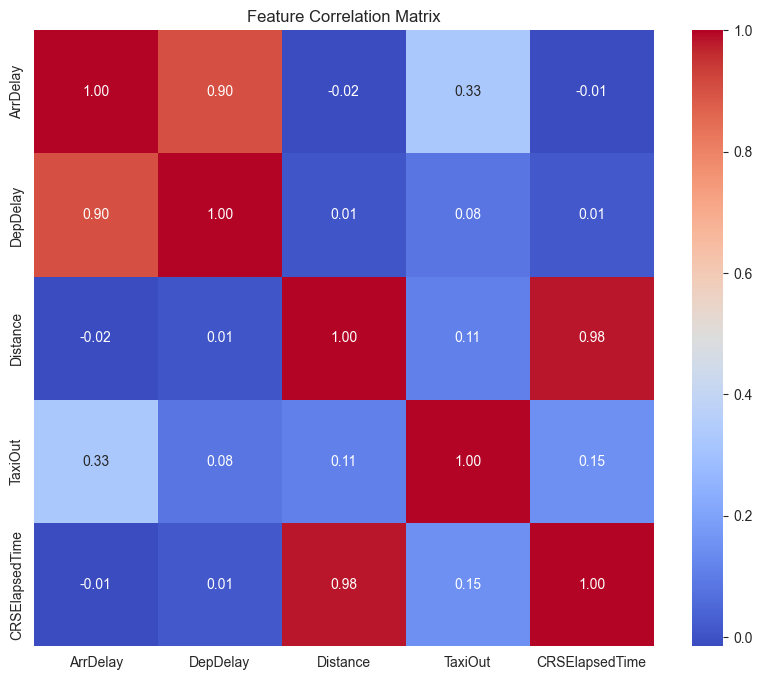

/var/folders/nh/fj6gh87d1nj8xz4w9_l7_q2r0000gn/T/ipykernel_49137/1467122068.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_null, x='Missing_Count', y='Feature', palette='viridis')


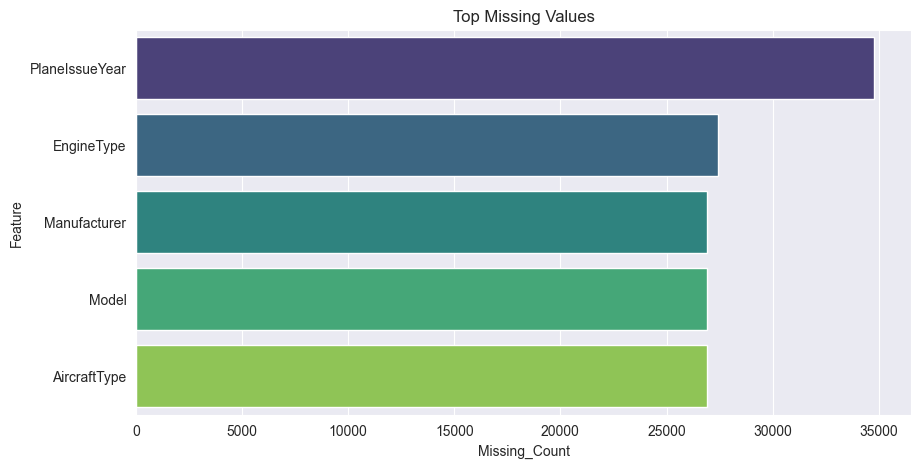

2026-01-08 00:39:12,704 - Trainer - INFO - Generating cyclic time features...
2026-01-08 00:39:12,748 - Trainer - INFO - Learning parameters and saving artifacts...
2026-01-08 00:39:40,588 - Trainer - INFO - Encoding Origin via MeanTarget       
2026-01-08 00:39:43,610 - Trainer - INFO - Encoding Dest via MeanTarget         
2026-01-08 00:39:46,430 - Trainer - INFO - Encoding EngineType via OneHot       
2026-01-08 00:39:49,691 - Trainer - INFO - Encoding AircraftType via OneHot     
2026-01-08 00:39:52,820 - Trainer - INFO - Encoding Manufacturer via OneHot     
2026-01-08 00:39:56,591 - Trainer - INFO - Encoding Model via MeanTarget        
2026-01-08 00:39:59,746 - Trainer - INFO - Encoding Year via OneHot             
2026-01-08 00:40:03,073 - Trainer - INFO - Encoding PlaneIssueYear via MeanTarget
2026-01-08 00:40:04,682 - Trainer - INFO - Saving Vectorizer model...           
2026-01-08 00:40:04,825 - Trainer - INFO - All artifacts saved successfully.


Model           | RMSE       | MAE        | R2        
-------------------------------------------------------


26/01/08 00:40:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/01/08 00:40:07 WARN Instrumentation: [9afc127b] regParam is zero, which might cause numerical instability and overfitting.
26/01/08 00:40:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
26/01/08 00:40:11 WARN Instrumentation: [9afc127b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


LinearReg       | 12.9551    | 7.6606     | 0.8753    


26/01/08 00:40:29 WARN MemoryStore: Not enough space to cache rdd_1240_6 in memory! (computed 19.0 MiB so far)
26/01/08 00:40:29 WARN BlockManager: Persisting block rdd_1240_6 to disk instead.
26/01/08 00:40:29 WARN MemoryStore: Not enough space to cache rdd_1240_4 in memory! (computed 28.5 MiB so far)
26/01/08 00:40:29 WARN BlockManager: Persisting block rdd_1240_4 to disk instead.
26/01/08 00:40:29 WARN MemoryStore: Not enough space to cache rdd_1240_10 in memory! (computed 28.5 MiB so far)
26/01/08 00:40:29 WARN BlockManager: Persisting block rdd_1240_10 to disk instead.
26/01/08 00:40:29 WARN MemoryStore: Not enough space to cache rdd_1240_1 in memory! (computed 12.6 MiB so far)
26/01/08 00:40:29 WARN BlockManager: Persisting block rdd_1240_1 to disk instead.
26/01/08 00:40:29 WARN MemoryStore: Not enough space to cache rdd_1240_2 in memory! (computed 45.0 MiB so far)
26/01/08 00:40:29 WARN BlockManager: Persisting block rdd_1240_2 to disk instead.
26/01/08 00:40:29 WARN MemoryStor

RandomForest    | 16.7975    | 9.8633     | 0.7903    
>>> Loading interpretation data...


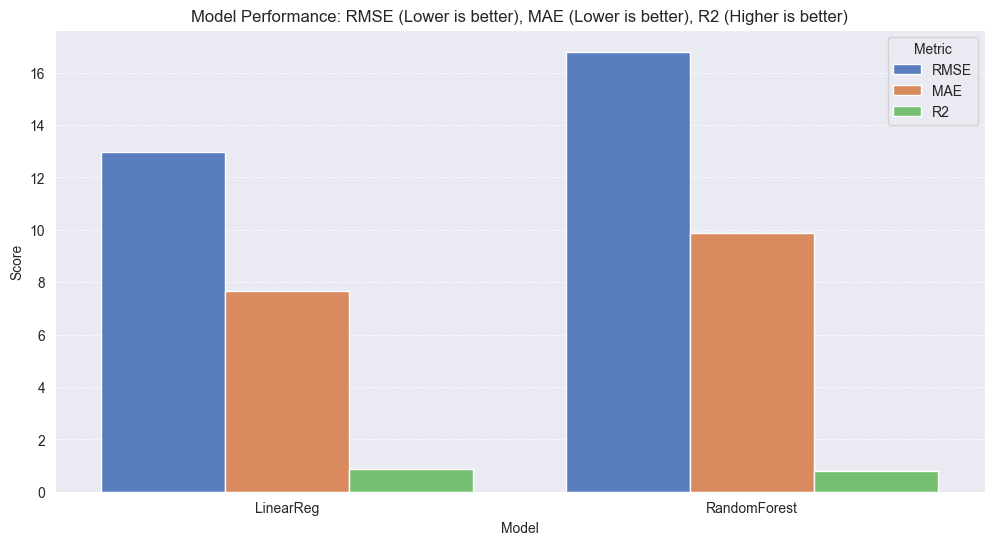

Winner based on RMSE: LinearReg


/var/folders/nh/fj6gh87d1nj8xz4w9_l7_q2r0000gn/T/ipykernel_49137/1467122068.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=winner_imp, x='Importance', y='Feature', palette='viridis')


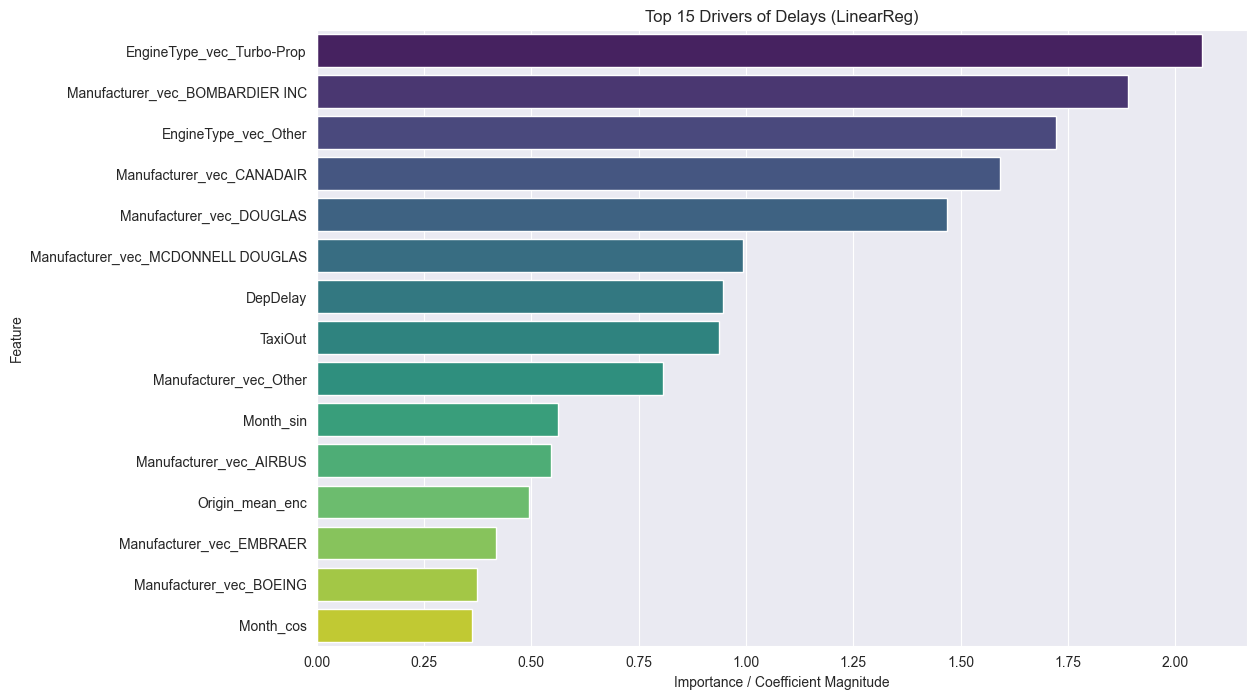

2026-01-08 00:40:56,850 - Trainer - INFO - Saving winner model (LinearReg) to best_model/retrained_best_model/...
2026-01-08 00:40:57,096 - Trainer - INFO - Generating final prediction CSV...
2026-01-08 00:40:58,825 - Trainer - INFO - Sample predictions saved to ./data/output_predictions.csv
2026-01-08 00:40:58,825 - Trainer - INFO - >>> Pipeline Finished Successfully <<<


In [7]:
# =================== 6. Execution Orchestrator ===================
import os

def run_pipeline():
    logger.info(">>> Starting Pipeline Execution <<<")
    
    # --- FIX START: Notebook Path Resolution ---
    # In Jupyter, '__file__' is not available. We use the current working directory.
    # We assume the notebook is running from the project root.
    project_root = os.path.abspath(".") 
    
    flights_path = os.path.join(project_root, Config.RAW_FLIGHTS_DIR, "*.csv.bz2")
    planes_path = os.path.join(project_root, Config.RAW_PLANES_FILE)

    # Debug print to verify path
    print(f"DEBUG: Project Root: {project_root}")
    print(f"DEBUG: Looking for flights data at: {flights_path}")
    # --- FIX END ---

    # 1. Load Data
    dm = DataManager(spark)
    # Use the resolved absolute paths
    flights = dm.load_raw_dataset(flights_path, "flights_all")
    planes = dm.load_raw_dataset(planes_path, "planes")
    
    # 2. Clean
    fp = FeaturePipeline(Config.ARTIFACTS_DIR)
    df_clean = fp.clean_and_standardize(flights, planes)
    
    # [NEW] Generate Evidence Graphs (EDA)
    # We take a sample to keep plotting fast
    generate_evidence_graphs(df_clean.sample(fraction=0.1, seed=42))
    
    # Feature Engineering
    df_engineered = fp.build_features(df_clean)
    train_df, test_df = df_engineered.randomSplit([0.8, 0.2], seed=42)
    
    # 3. Generate Artifacts
    feature_cols = fp.fit_and_save_artifacts(train_df)
    
    # 4. Transform Data (App Simulation)
    # Reload artifacts to ensure strict separation
    with open(os.path.join(Config.ARTIFACTS_DIR, 'imputer_maps.json')) as f: imputers = json.load(f)
    with open(os.path.join(Config.ARTIFACTS_DIR, 'non_aggregated.json')) as f: groups = json.load(f)
    with open(os.path.join(Config.ARTIFACTS_DIR, 'encode_types.json')) as f: enc_types = json.load(f)
    
    def transform_dataset(data):
        # Apply Imputers
        for c, rules in imputers.items():
            if c in data.columns: data = data.fillna(rules['fill_value'], subset=[c])
        # Apply Grouping
        for c, cats in groups.items():
            if c in data.columns:
                data = data.withColumn(f"{c}_agg", F.when(F.col(c).isin(cats), F.col(c)).otherwise(F.lit("Other")))
        # Apply Encodings
        for agg_col, method in enc_types.items():
            base = agg_col.replace("_agg", "")
            if method == 'binary':
                model = PipelineModel.load(os.path.join(Config.ARTIFACTS_DIR, f"{base}_aggregated_encoder"))
                data = model.transform(data)
            elif method == 'mean':
                mapping = spark.read.csv(os.path.join(Config.ARTIFACTS_DIR, f"{base}_aggregated_encoder.csv"), header=True, inferSchema=True)
                data = data.join(mapping, on=agg_col, how='left').fillna(0, subset=[f"{base}_mean_enc"])
        # Vectorize
        vec_model = PipelineModel.load(os.path.join(Config.ARTIFACTS_DIR, 'vectorizer'))
        return vec_model.transform(data)

    train_ready = transform_dataset(train_df)
    test_ready = transform_dataset(test_df)

    # 5. Train & Evaluate (Pass feature_cols for importance mapping)
    # [UPDATED] Trainer now saves CSVs for interpretation
    trainer = ModelTrainer(Config.ARTIFACTS_DIR)
    best_name, best_model = trainer.train_and_evaluate(train_ready, test_ready, feature_cols)
    
    # [NEW] Interpret Models
    interpret_models(Config.ARTIFACTS_DIR)
    
    # 6. Save Best Model
    logger.info(f"Saving winner model ({best_name}) to {Config.MODEL_OUTPUT_DIR}...")
    final_pipe = PipelineModel(stages=[best_model])
    final_pipe.write().overwrite().save(Config.MODEL_OUTPUT_DIR)
    
    # 7. [NEW] Generate & Save Predictions (The missing part)
    logger.info("Generating final prediction CSV...")
    
    # Reload the saved model to verify it works
    loaded_model = PipelineModel.load(Config.MODEL_OUTPUT_DIR)
    predictions = loaded_model.transform(test_ready)
    
    # Filter out vector columns to avoid CSV crashes
    cols_to_save = [field.name for field in predictions.schema.fields 
                    if not isinstance(field.dataType, VectorUDT) and field.name != 'scaledFeatures']
    
    output_csv = "./data/output_predictions.csv"
    
    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    
    predictions.select(cols_to_save).limit(100).write.mode("overwrite").option("header", "true").csv(output_csv)
    logger.info(f"Sample predictions saved to {output_csv}")
    
    logger.info(">>> Pipeline Finished Successfully <<<")

if __name__ == "__main__":
    run_pipeline()